In [57]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import os
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [58]:
data_dir = 'D:\\Hackathon_project\\Dataset'
testing = 'D:\\Hackathon_project\\image'

In [59]:
batch_size = 32
img_height = 180
img_width = 180

In [60]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  directory = data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1557 files belonging to 2 classes.
Using 1246 files for training.


In [61]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  directory = data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1557 files belonging to 2 classes.
Using 311 files for validation.


In [62]:
class_names = train_ds.class_names
print(class_names)


['defected', 'no_defected']


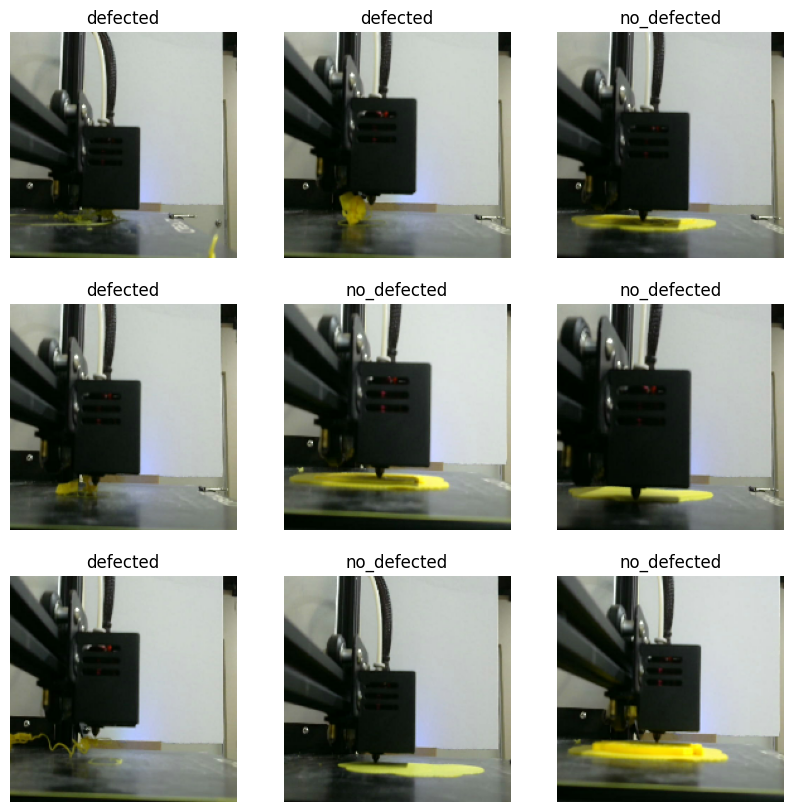

In [63]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [64]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [65]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [66]:
normalization_layer = layers.Rescaling(1./255)

In [67]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [68]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

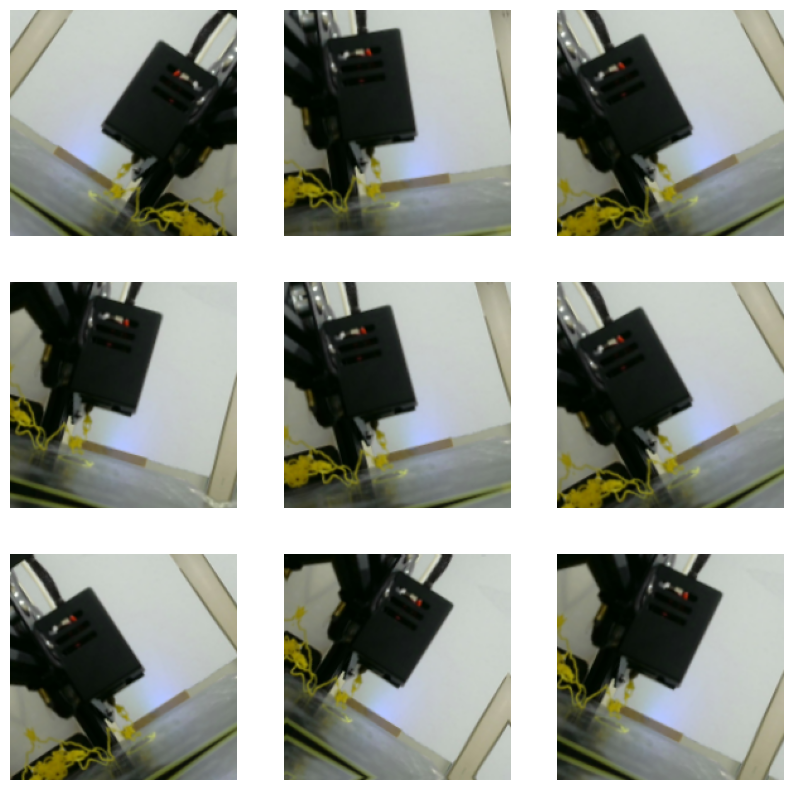

In [69]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [70]:
num_classes = len(class_names)
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [71]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [72]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [73]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 0.5343 - loss: 0.7985 - val_accuracy: 0.7299 - val_loss: 0.4302
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7984 - loss: 0.4120 - val_accuracy: 0.8553 - val_loss: 0.3553
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.8661 - loss: 0.3230 - val_accuracy: 0.8360 - val_loss: 0.3707
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.8580 - loss: 0.3146 - val_accuracy: 0.8810 - val_loss: 0.2326
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.8960 - loss: 0.2429 - val_accuracy: 0.9357 - val_loss: 0.1430
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.8943 - loss: 0.2527 - val_accuracy: 0.9518 - val_loss: 0.1391
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.8995 - loss: 0.2192 - val_accuracy: 0.9775 - val_loss: 0.1020
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.9499 - loss: 0.1554 - val_accuracy: 0.

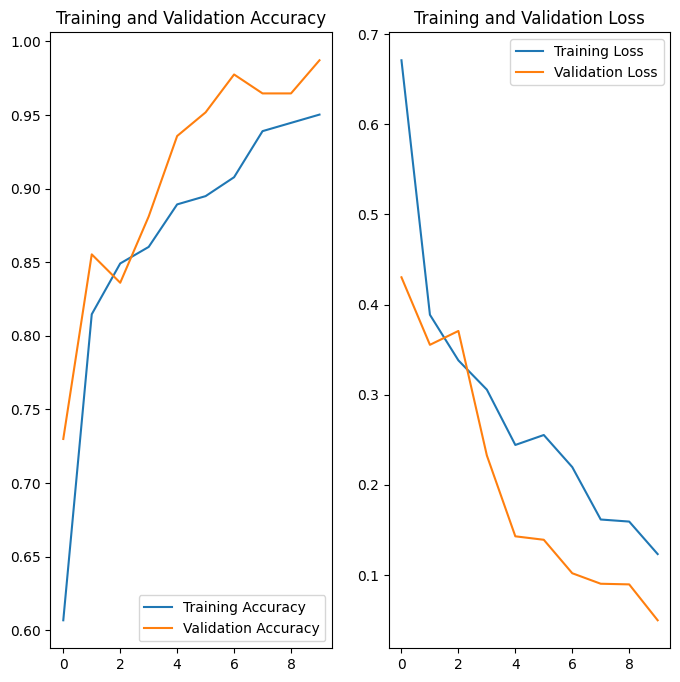

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [75]:
from tensorflow.keras.models import save_model

model.save('D:\\Hackathon_project\\backend\\model.keras')  


from tensorflow.keras.models import load_model


model = load_model('D:\\Hackathon_project\\backend\\model.keras')

In [76]:
print(type(model))


<class 'keras.src.models.sequential.Sequential'>


In [77]:

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory=testing,  
    image_size=(img_height, img_width),
    batch_size=batch_size,  
    shuffle=False  
)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

for images, labels in test_ds:
    predictions = model.predict(images)

    predicted_classes = np.argmax(predictions, axis=1)

    
    print("Predicted class indices:", predicted_classes)
    print("Predicted probabilities:", predictions)
    print("True labels:", labels.numpy())

Found 12 files belonging to 1 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted class indices: [0 0 0 0 0 0 0 1 1 1 1 1]
Predicted probabilities: [[  2.8325846  -2.3529994]
 [  2.8400228  -2.360687 ]
 [  2.744559   -1.874769 ]
 [  2.7741103  -2.011676 ]
 [  2.678922   -2.2566874]
 [  3.834063   -3.1390064]
 [  2.9165852  -2.4059577]
 [-11.458305    9.454994 ]
 [-10.935166    9.282164 ]
 [ -8.60133     7.369034 ]
 [ -7.07431     5.789077 ]
 [ -8.439684    6.212725 ]]
True labels: [0 0 0 0 0 0 0 0 0 0 0 0]
